In [1]:
import sys  
sys.path.insert(1, '../../')

import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler

from classifiers.nn.siamese.siamese_model import SiameseNetwork
from datasets.siamese_dataset import SiameseNetworkDataset
from determining.random_settings import determine_random

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
determine_random()
# Автоматическое определение, где запускать код: на Nvidia GPU или на CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100, 100)),
                                     transforms.ToTensor()
                                     ])

train_dataset = SiameseNetworkDataset(
    image_folder_dataset=datasets.ImageFolder(root="../../datasets/siamese/data/faces/training/"),
    transform=transformation)
test_dataset = SiameseNetworkDataset(
    image_folder_dataset=datasets.ImageFolder(root="../../datasets/siamese/data/faces/testing/"),
    transform=transformation)
trainset = DataLoader(train_dataset,
                      sampler=RandomSampler(train_dataset),
                      num_workers=8,
                      batch_size=64)
testset = DataLoader(test_dataset, num_workers=2, batch_size=1, sampler=RandomSampler(test_dataset))

model = SiameseNetwork().to(device)

In [15]:
model.start_train(trainset, 100)

Epoch 1/100, Loss: 0.014714105054736137
Epoch 2/100, Loss: 0.011513645760715008
Epoch 3/100, Loss: 0.022375846281647682
Epoch 4/100, Loss: 0.013080397620797157
Epoch 5/100, Loss: 0.017298545688390732
Epoch 6/100, Loss: 0.006556796841323376
Epoch 7/100, Loss: 0.014304088428616524
Epoch 8/100, Loss: 0.009280682541429996
Epoch 9/100, Loss: 0.007936700247228146
Epoch 10/100, Loss: 0.013435130007565022
Epoch 11/100, Loss: 0.005640128627419472
Epoch 12/100, Loss: 0.005808801855891943
Epoch 13/100, Loss: 0.0030348175205290318
Epoch 14/100, Loss: 0.004958263132721186
Epoch 15/100, Loss: 0.004913392476737499
Epoch 16/100, Loss: 0.006381541024893522
Epoch 17/100, Loss: 0.004391997586935759
Epoch 18/100, Loss: 0.00548521289601922
Epoch 19/100, Loss: 0.004408538341522217
Epoch 20/100, Loss: 0.005196211859583855
Epoch 21/100, Loss: 0.0013243603752925992
Epoch 22/100, Loss: 0.002388367895036936
Epoch 23/100, Loss: 0.0017583880107849836
Epoch 24/100, Loss: 0.004534153267741203
Epoch 25/100, Loss: 0.0

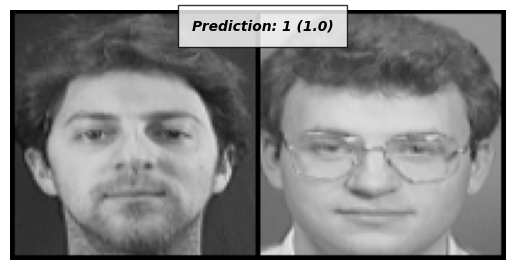

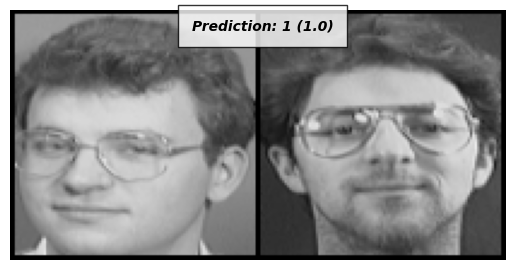

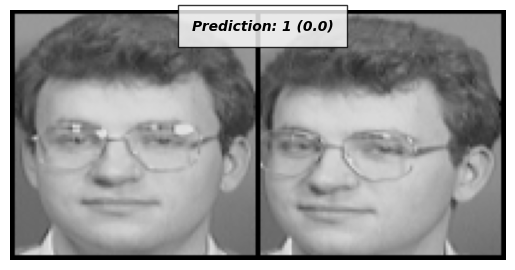

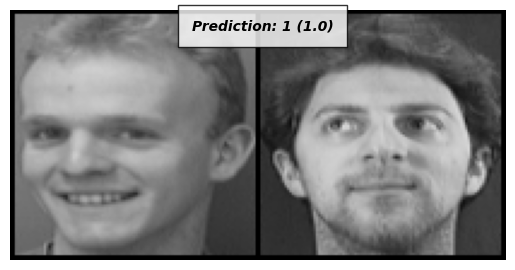

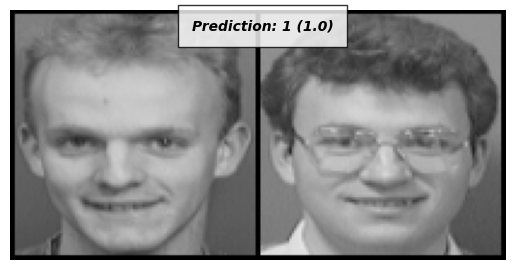

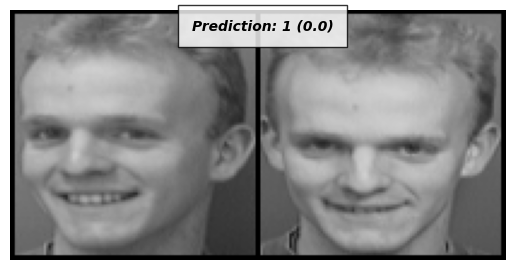

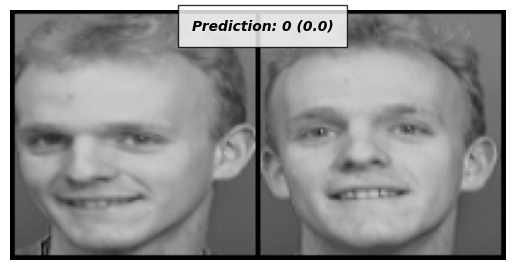

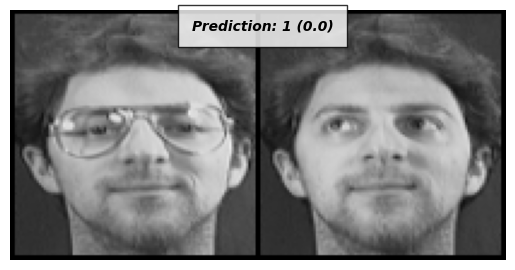

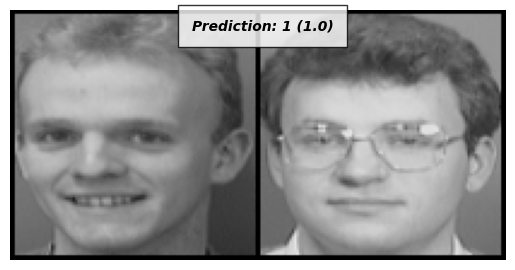

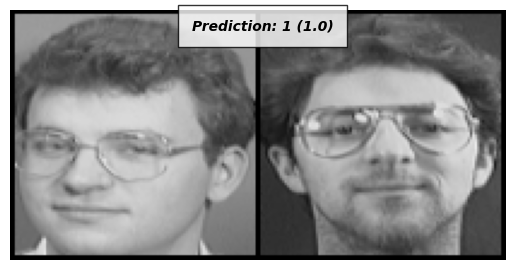

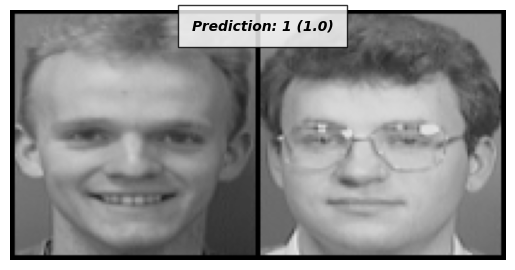

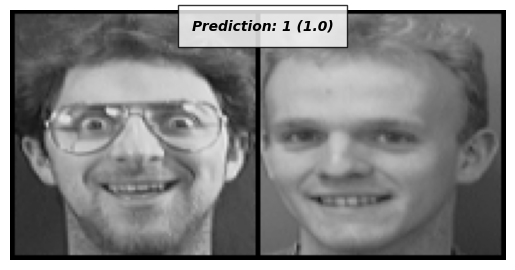

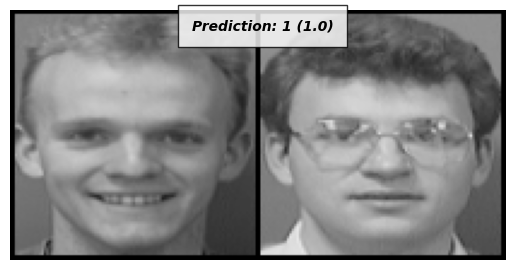

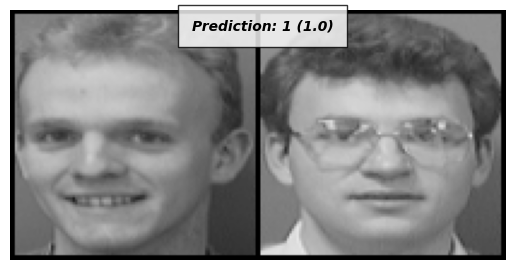

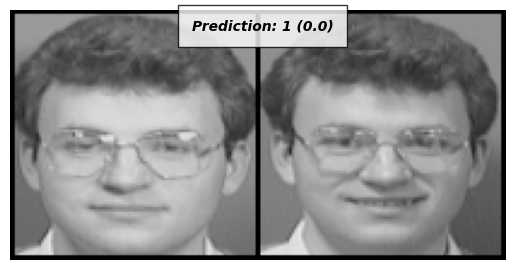

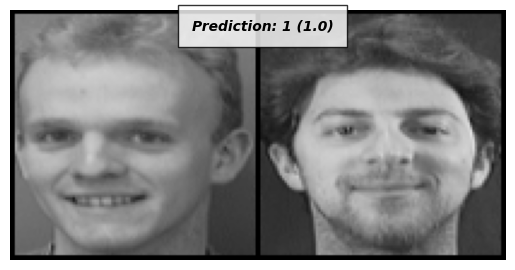

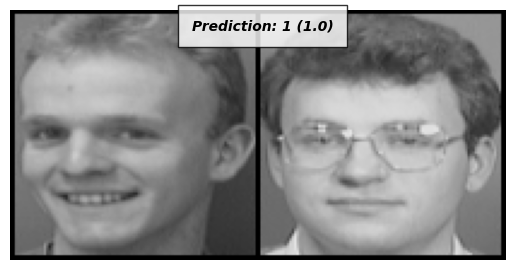

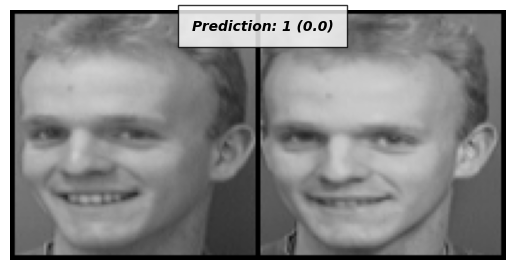

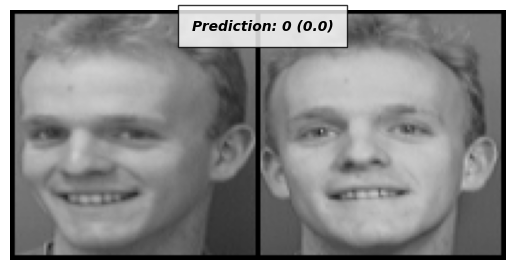

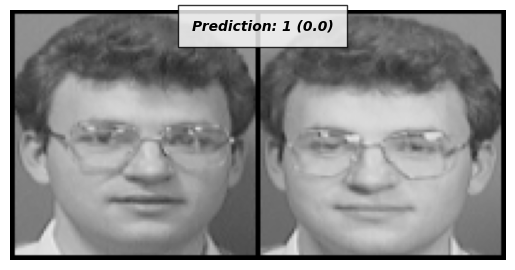

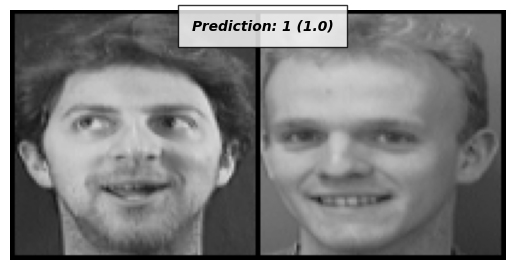

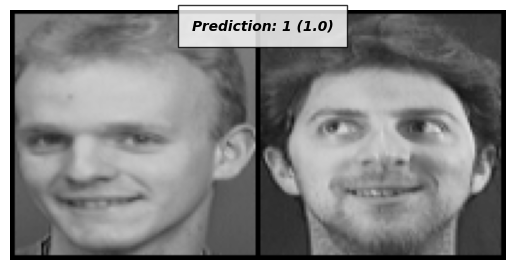

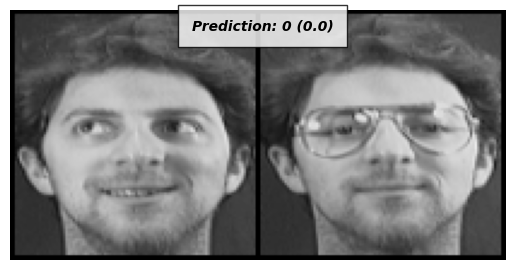

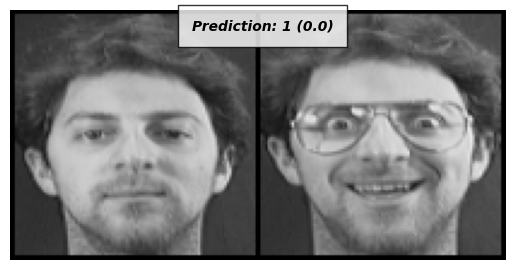

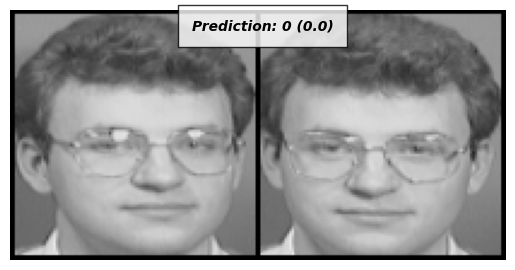

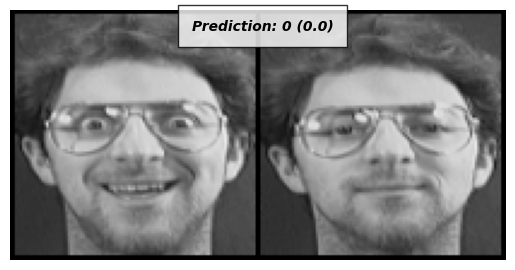

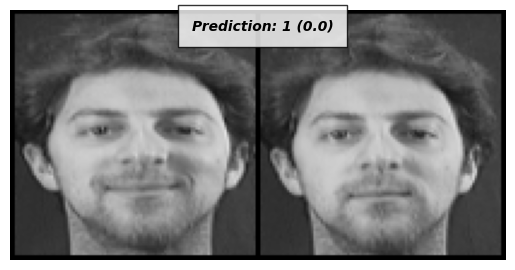

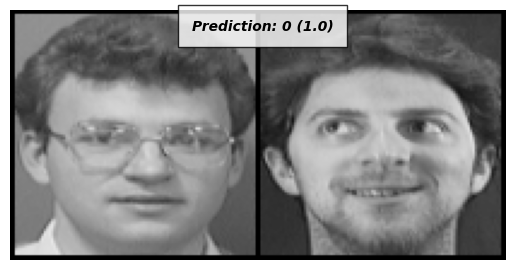

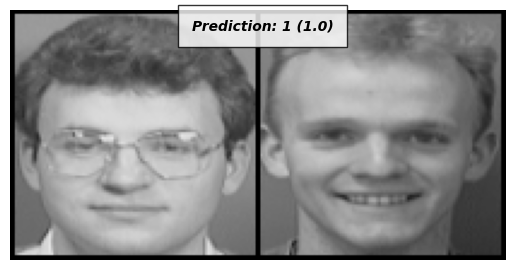

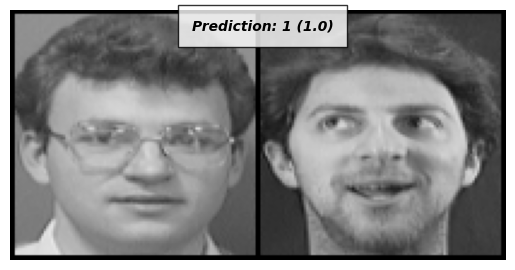

In [16]:
model.do_test(testset)

0.5891891891891892
699

0.5891891891891892
699

0.5891891891891892
699


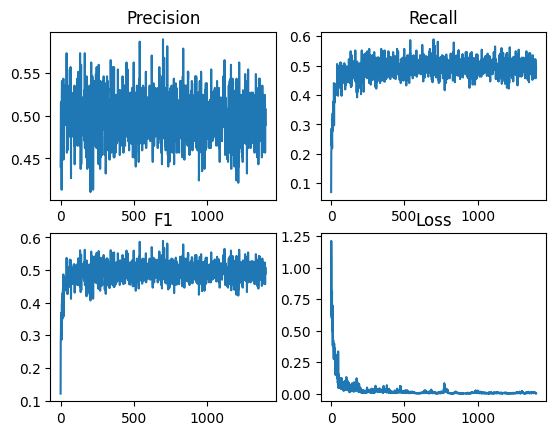

In [17]:
max_precision = 0
max_precision_i = 0
max_f1 = 0
max_f1_i = 0
max_recall = 0
max_recall_i = 0

for i, (stat) in enumerate(model.train_stat):
    # print(i)
    # print(f'Precision: {stat.precision:.2f}')
    # print(f'Recall: {stat.recall:.2f}')
    # print(f'F1 Score: {stat.f1:.2f}')
    # print(f'Loss: {stat.loss:.2f}')
    if (max_precision < stat.precision):
        max_precision = stat.precision
        max_precision_i = i

    if (max_f1 < stat.f1):
        max_f1 = stat.f1
        max_f1_i = i

    if (max_recall < stat.recall):
        max_recall = stat.recall
        max_recall_i = i
print(max_precision)
print(max_precision_i)
print()
print(max_recall)
print(max_recall_i)
print()
print(max_f1)
print(max_f1_i)

# Get the angles from 0 to 2 pie (360 degree) in narray object
X = np.arange(0, len(model.train_stat), 1)

# Using built-in trigonometric function we can directly plot
# the given cosine wave for the given angles
Y1 = [i.precision for i in model.train_stat]
Y2 = [i.recall for i in model.train_stat]
Y3 = [i.f1 for i in model.train_stat]
Y4 = [i.loss for i in model.train_stat]

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(X, Y1)
axis[0, 0].set_title("Precision")

# For Cosine Function
axis[0, 1].plot(X, Y2)
axis[0, 1].set_title("Recall")

# For Tangent Function
axis[1, 0].plot(X, Y3)
axis[1, 0].set_title("F1")

# For Tanh Function
axis[1, 1].plot(X, Y4)
axis[1, 1].set_title("Loss")

# Combine all the operations and display
plt.show()

In [18]:
print(f'Precision: {model.test_stat.precision:.2f}')
print(f'Recall: {model.test_stat.recall:.2f}')
print(f'F1 Score: {model.test_stat.f1:.2f}')

Precision: 0.57
Recall: 0.80
F1 Score: 0.66
